In [1]:
# Common DS
import pandas as pd
import numpy as np
import scipy.stats as stats

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Helpful Stuff
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2

from splitter import splitter

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Check to see if win_pct should be removed as a column, or if null rows should be removed instead.

##### Acquire 'tome_prep' modified to return win_prob in the dataframe

In [ ]:
from acquire import tome_prep

In [ ]:
df = tome_prep()

In [ ]:
df.info()
df.head()

In [ ]:
# Create column with or without win prob - then analyze differences
df['has_win_prob'] = np.where(df.win_prob.isnull() == False, 'has_win_prob','no_win_prob')

In [ ]:
y = 'abs_time'

In [ ]:
wp = df[df.has_win_prob == 'has_win_prob']
nwp = df[df.has_win_prob == 'no_win_prob']

In [ ]:
wp[y].max()

In [ ]:
plt.figure(figsize = (12,12))
sns.boxplot(data = df, x='has_win_prob',y=y)

##### This indicates that the time is cut off at a certain point, so I would rather lose this as a feature (when it afect is likely captures in point_margin) than lose those shots.

## Split off a training dataframe for EDA

##### Acquire original 'tome_prep' , which does not return win_prob in the dataframe

In [2]:
from acquire import tome_prep

In [3]:
df = tome_prep()

##### Split around the target 'shot_result'

In [4]:
train, validate, test = splitter(df, target = 'shot_result')

Train = 47131 rows (56.0%) | Validate = 20200 rows (24.0%) | Test = 16833 rows (20.0%)


In [5]:
train.head()

,player,player_id,team,team_id,game_id,home,period,abs_time,play_time,since_rest,loc_x,loc_y,zone,shot_type,score_margin,points,fg_pct,shot_result
22101,Jeff Green,201145,Denver Nuggets,1610612743,22100794,True,1,166,166.0,166.0,-230,-6,R Center,Jump Shot,2,0,0.00,Missed Shot
54605,RJ Barrett,1629628,New York Knicks,1610612752,22101140,True,2,1077,742.0,22.0,200,138,L Below Break/Corner,Jump Shot,0,10,0.83,Missed Shot
12186,Jonas Valanciunas,202685,New Orleans Pelicans,1610612740,22100179,True,1,74,74.0,74.0,-83,257,Center,Jump Shot,-3,0,0.00,Missed Shot
19168,Reggie Bullock,203493,Dallas Mavericks,1610612742,22100954,True,1,369,369.0,369.0,11,267,L Center,Pullup Jump shot,-6,0,0.00,Missed Shot
80553,Bojan Bogdanovic,202711,Utah Jazz,1610612762,22101150,True,3,1697,818.0,257.0,-223,5,R Center,Jump Shot,6,6,0.27,Missed Shot


Create lists of continuous and categorical Columns:

In [ ]:
train_cont = ['abs_time', 'play_time', 'since_rest', 'loc_x', 'loc_y','score_margin', 'points', 'fg_pct']
train_cat = ['home', 'period','zone','shot_type']
train_tar = ['shot_result_encoded']

In [ ]:
train_cont

Create Encoded 'shot_result' (convenient to show percentages of shots)

In [ ]:
train['shot_result_encoded'] = np.where(train['shot_result'] == 'Made Shot', 1,0)

#### Variable Exploration

In [ ]:
# Create a correlation matrix from the continuous numerical columns
df_num_cols = train[train_cont]
corr = df_num_cols.corr()

# Pass correlation matrix on to sns heatmap
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap="flare", mask=np.triu(corr))
plt.show()

In [ ]:
# Create a left column that shows distributions for each cat next to it's barplot

In [ ]:
plt.figure(figsize=(32,32))
i=1
for col in train_cat:
#     plt.subplot(2, 4, i)
#     Create a plot showing distribution of cat variable
#     i+=1
    plt.subplot(4, 1, i)
    sns.barplot(x = col, y = 'shot_result_encoded', data=train, alpha=.8, color='lightblue')
    plt.axhline(train['shot_result_encoded'].mean(), ls='--', color='gray')
    i+=1
plt.show()

In [ ]:
plt.figure(figsize = (12,12))
sns.lmplot(data = train, x=col, y='shot_result_encoded')
plt.show()

In [ ]:
plt.figure(figsize=(16,16))
i=1
for col in train_cont:
#     plt.subplot(2, 4, i)
#     Create a plot showing distribution of cat variable
#     i+=1
    plt.subplot(2, 4, i)
    sns.boxenplot(y = col, x = 'shot_result', data=train)
    plt.axhline(train[col].mean(), ls='--', color='gray')
    i+=1
plt.show()

In [ ]:
train['points'] = np.where(train.shot_result == 'Made Shot', train.points - 3, train.points)

In [ ]:
train

In [ ]:
plt.figure(figsize = (44,8))
sns.lmplot(data=train, y='points', x='since_rest', hue='shot_result')
plt.show()

##### Might show freshness is key to making shots!

In [51]:
df_working = df.copy()

In [52]:
df_working['shot_result'] = np.where(df_working.shot_result == 'Made Shot',1,0)

In [53]:
boost = pd.DataFrame(df_working.groupby(['player','game_id']).shot_result.sum())

In [54]:
boost = boost.reset_index()

In [55]:
boost = boost.rename(columns = {'shot_result':"made_threes"})

In [56]:
glist = pd.Series(list(pd.DataFrame(df_working.groupby(['player','game_id']).shot_result.mean()).shot_result.values))

In [57]:
game_threes = pd.concat([boost,glist], axis =1)
game_threes = game_threes.rename(columns = {0:'game_three_pct'})

In [58]:
game_threes['per_game_3p_misses'] = (game_threes.made_threes/game_threes.game_three_pct) - game_threes.made_threes

In [59]:
game_threes['per_game_3pa'] = (game_threes.made_threes/game_threes.game_three_pct)

##### Game Score V1
3PM multiplied by 3P%

In [60]:
game_threes['three_score_v1'] = game_threes.made_threes * game_threes.game_three_pct

In [61]:
game_threes.sort_values(by = 'three_score_v1', ascending = False)

,player,game_id,made_threes,game_three_pct,per_game_3p_misses,per_game_3pa,three_score_v1
17461,Saddiq Bey,22101045,10,0.769231,3.0,13.0,7.692308
6280,Evan Fournier,22100578,10,0.769231,3.0,13.0,7.692308
13816,Malik Beasley,22100986,11,0.647059,6.0,17.0,7.117647
16892,Ricky Rubio,22100140,8,0.888889,1.0,9.0,7.111111
16172,Patty Mills,22100001,7,1.000000,0.0,7.0,7.000000
...,...,...,...,...,...,...,...
4521,DeAndre' Bembry,22100706,0,0.000000,NaN,NaN,0.000000
13410,Lou Williams,22100242,0,0.000000,NaN,NaN,0.000000
13406,Lou Williams,22100120,0,0.000000,NaN,NaN,0.000000
13405,Lou Williams,22100113,0,0.000000,NaN,NaN,0.000000


##### Game Score V2
3PM multiplied by (1 - 3P%)/2 + 3P% -> Reduce the impact of missing shots by 1/2

In [62]:
game_threes['three_score_v2'] = game_threes.made_threes * (game_threes.game_three_pct + ((1 - game_threes.game_three_pct)/2))

In [63]:
game_threes.sort_values(by = 'three_score_v1', ascending = False)

,player,game_id,made_threes,game_three_pct,per_game_3p_misses,per_game_3pa,three_score_v1,three_score_v2
17461,Saddiq Bey,22101045,10,0.769231,3.0,13.0,7.692308,8.846154
6280,Evan Fournier,22100578,10,0.769231,3.0,13.0,7.692308,8.846154
13816,Malik Beasley,22100986,11,0.647059,6.0,17.0,7.117647,9.058824
16892,Ricky Rubio,22100140,8,0.888889,1.0,9.0,7.111111,7.555556
16172,Patty Mills,22100001,7,1.000000,0.0,7.0,7.000000,7.000000
...,...,...,...,...,...,...,...,...
4521,DeAndre' Bembry,22100706,0,0.000000,NaN,NaN,0.000000,0.000000
13410,Lou Williams,22100242,0,0.000000,NaN,NaN,0.000000,0.000000
13406,Lou Williams,22100120,0,0.000000,NaN,NaN,0.000000,0.000000
13405,Lou Williams,22100113,0,0.000000,NaN,NaN,0.000000,0.000000


##### Game Score Three
made^2/missed

In [64]:
game_threes = game_threes.fillna(0)

In [65]:
game_threes['three_score_v3'] = game_threes.made_threes**2/game_threes.per_game_3p_misses

In [66]:
game_threes = game_threes.fillna(0)

In [67]:
three_score_v3_list = []
for row in game_threes.three_score_v3:
    if row == np.inf:
        row = 0
    else:
        row = row
    three_score_v3_list.append(row)

In [68]:
game_threes['three_score_v3'] = three_score_v3_list

#### Now aggregate all into season

In [69]:
season_threes = game_threes.groupby('player').agg('mean')

In [70]:
ranker = [n+1 for n in range(555)]

Ran this ranker against sorted values of v1 and v2 scores as well as made_threes and game_three_pct

In [71]:
season_threes.columns

Index(['game_id', 'made_threes', 'game_three_pct', 'per_game_3p_misses',
       'per_game_3pa', 'three_score_v1', 'three_score_v2', 'three_score_v3'],
      dtype='object')

In [72]:
rank_columns = ['made_threes', 'game_three_pct', 'per_game_3p_misses','per_game_3pa', 'three_score_v1', 'three_score_v2', 'three_score_v3']

In [73]:
for metric in rank_columns:
    rank = f'{metric}_rank'
    season_threes = season_threes.sort_values(by = metric, ascending = False)
    season_threes[rank] = ranker

In [74]:
season_threes

,game_id,made_threes,game_three_pct,per_game_3p_misses,per_game_3pa,three_score_v1,three_score_v2,three_score_v3,made_threes_rank,game_three_pct_rank,per_game_3p_misses_rank,per_game_3pa_rank,three_score_v1_rank,three_score_v2_rank,three_score_v3_rank
player,,,,,,,,,,,,,,,
Joe Harris,2.210010e+07,2.928571,0.475417,3.357143,6.285714,1.598330,2.263451,4.775765,18,23,51,40,4,9,1
Lonzo Ball,2.210028e+07,3.142857,0.424023,4.085714,7.228571,1.598913,2.370885,4.399286,7,40,28,21,3,5,2
Stephen Curry,2.210053e+07,4.125000,0.397276,6.203125,10.328125,1.890991,3.007995,4.107970,1,71,1,1,1,1,3
Luke Kennard,2.210059e+07,2.710145,0.466221,3.231884,5.942029,1.443182,2.076663,4.088475,26,26,58,49,10,23,4
Klay Thompson,2.210090e+07,3.562500,0.374824,5.312500,8.875000,1.670665,2.616582,3.822966,3,121,4,4,2,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xavier Sneed,2.210092e+07,0.166667,0.166667,0.000000,0.166667,0.166667,0.166667,0.000000,504,486,550,504,492,502,551
Myles Powell,2.210062e+07,0.200000,0.200000,0.000000,0.200000,0.200000,0.200000,0.000000,500,464,553,502,484,497,552
Quinndary Weatherspoon,2.210090e+07,0.200000,0.200000,0.000000,0.200000,0.200000,0.200000,0.000000,501,465,552,503,483,496,553


In [79]:
df[df.player == 'Zylan Cheatham']

,player,player_id,team,team_id,game_id,home,period,abs_time,play_time,since_rest,loc_x,loc_y,zone,shot_type,score_margin,points,fg_pct,shot_result
83413,Zylan Cheatham,1629597,Utah Jazz,1610612762,22100624,True,3,1900,1900.0,127.0,199,164,L Below Break/Corner,Jump Shot,-23,0,1.0,Missed Shot
83414,Zylan Cheatham,1629597,Utah Jazz,1610612762,22100624,True,3,1953,1953.0,180.0,-229,1,R Center,Jump Shot,-25,0,0.0,Missed Shot


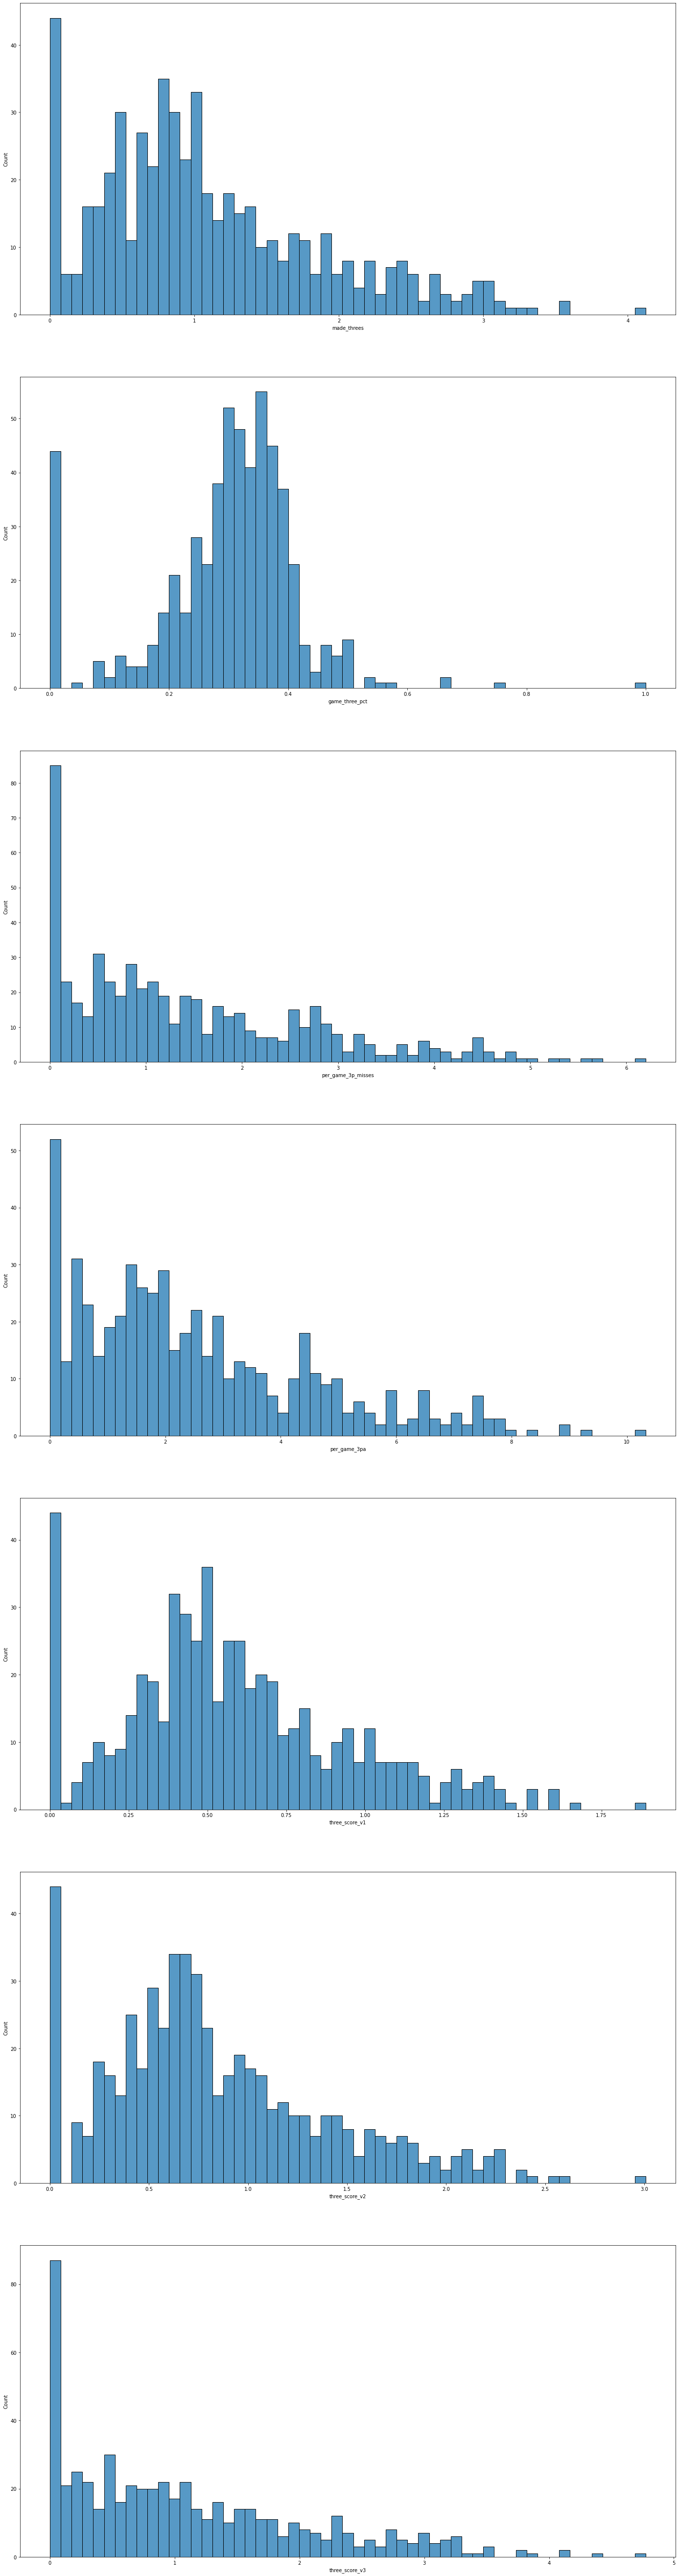

In [78]:
plt.figure(figsize = (24,96))
plt.subplot(711)
sns.histplot(data = season_threes, x='made_threes', bins = 55)
plt.subplot(712)
sns.histplot(data = season_threes, x='game_three_pct', bins = 55)
plt.subplot(713)
sns.histplot(data = season_threes, x='per_game_3p_misses', bins = 55)
plt.subplot(714)
sns.histplot(data = season_threes, x='per_game_3pa', bins = 55)
plt.subplot(715)
sns.histplot(data = season_threes, x='three_score_v1', bins = 55)
plt.subplot(716)
sns.histplot(data = season_threes, x='three_score_v2', bins = 55)
plt.subplot(717)
sns.histplot(data = season_threes, x='three_score_v3', bins = 55)
plt.show()

## ADD IN GAME RESULTS back to game_threes

In [80]:
season_threes.to_csv('season_3pt_scores.csv')

In [ ]:
season_tots = game_threes.groupby('player').agg('sum')

In [ ]:
season_tots.sort_values('made_threes', ascending = False)

In [ ]:
pd.crosstab(train.zone,train.shot_type)